<td>
   <a target="_blank" href="https://labelbox.com" ><img src="https://labelbox.com/blog/content/images/2021/02/logo-v4.svg" width=256/></a>
</td>

<td>
<a href="https://colab.research.google.com/github/Labelbox/labelbox-python/blob/master/examples/exports/composite_mask_export.ipynb" target="_blank"><img
src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</td>

<td>
<a href="https://github.com/Labelbox/labelbox-python/tree/master/examples/exports/composite_mask_export.ipynb" target="_blank"><img
src="https://img.shields.io/badge/GitHub-100000?logo=github&logoColor=white" alt="GitHub"></a>
</td>

# Export composite masks

Composite masks are a combination of mask instances grouped in a single mask URL. 

The purpose of this demo is to demonstrate how to transition from exporting single masks to exporting composite masks. 

## Imports

In [ ]:
%pip install -q "labelbox[data]"

In [ ]:
import labelbox as lb
import urllib.request
from PIL import Image
import json


## API Key and Client
See the developer guide for [creating an API key](https://docs.labelbox.com/reference/create-api-key).

In [ ]:
API_KEY = ""
client = lb.Client(api_key=API_KEY)
client.enable_experimental = True ## This is required if using the export() streamable method

## Key differences between single mask instance and composite mask.

#### Composite masks
1. A single mask url contains all mask instances from a single label. For videos a composite mask contains all mask instances for the frame in each label. 
2. The export and mask URL adhere to the following convention:
  - ***Image example***
```json 
  {
    "composite_mask": {
      "url": "https://api.labelbox.com/api/v1/tasks/{task_id}/masks/{composite_mask_id}",
      "color_rgb": [
          142,
          220,
          196
      ]
    }
  }
```
  - ***Video example*** :
  The export will adhere to the following URL convention by default. However, the image's URL convention is also considered valid.
```json
  {
    "composite_mask": {
      "url": "https://api.labelbox.com/api/v1/tasks/{task_id}/masks/{composite_mask_id}/index/{frame_number}",
      "color_rgb": [
        224,
        17,
        103
      ]
    }
  }
```
3. A unique RGB color is assigned to each mask instance. The example below shows a composite mask of a label, and while it contains all mask instances, only the RGB color associated with this particular annotation will be filled in under the ```color_rgb``` field.

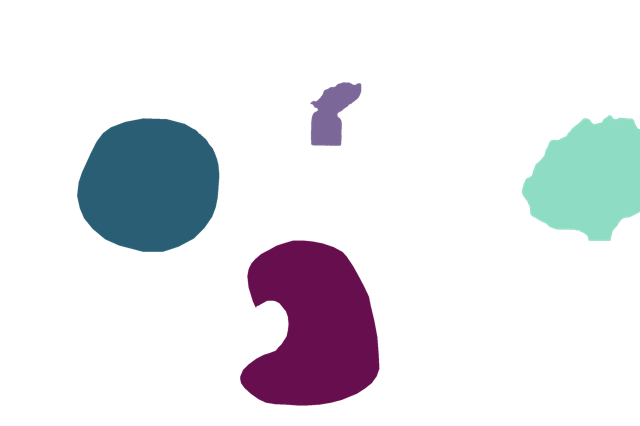

In [ ]:
# Example on how to fetch a composite mask
# The mask here shows all the mask instances associated with a label
task_id = ""
composite_mask_id = ""

mask_url = f'https://api.labelbox.com/api/v1/tasks/{task_id}/masks/{composite_mask_id}'
req = urllib.request.Request(mask_url, headers=client.headers)
image = Image.open(urllib.request.urlopen(req))
w, h = image.size
new_w = w // 4
new_h = h // 4

image.resize((new_w, new_h), Image.BICUBIC)

Here's an example of an entry featuring a composite mask containing the mask instance's RGB color uniquely associated with the annotation.

```json
    {
      "feature_id": "clpk3ow9u006f14vs2w5qa9l3",
      "feature_schema_id": "clpk3nvrv05bh08ua8fwqavng",
      "name": "mask",
      "value": "mask",
      "annotation_kind": "ImageSegmentationMask",
      "classifications": [],
      "composite_mask": {
          "url": "https://api.labelbox.com/api/v1/tasks/{task_id}/masks/{composite_mask_id}",
          "color_rgb": [
              123,
              103,
              152
          ]
      }
    }
```
- rgb(123,103,152) = Purple


---

#### Single mask instance:
We are planning on removing single mask instances, but for now they will be displayed adjecent to the composite mask.
1. A single mask instance and mask url is generated for each individual annotation for each label.
2. The export and mask URL adhere to the following convention:  
```json
      {
        "mask": {
              "url": "https://api.labelbox.com/api/v1/projects/{project_id}/annotations/{feature_id}/index/1/mask"
          }
      }

```
3. RGB color is not present

## Create an export from an Image project with mask annotations
To better showcase composite masks, make sure you have different mask tools and mask annotations in your project

In [ ]:
# Insert the project ID of the project from which you wish to export data rows.
PROJECT_ID = ""
project = client.get_project(PROJECT_ID)

In [ ]:
export_params= {
  "attachments": True,
  "metadata_fields": True,
  "data_row_details": True,
  "project_details": True,
  "label_details": True,
  "performance_details": True,
  "interpolated_frames": True
}

filters= {}

# export() is the streamable option of exports V2, for more information please visit our documentation:
# https://docs.labelbox.com/reference/label-export#export-v2-methods

export_task = project.export(params=export_params, filters=filters)
export_task.wait_till_done()

if export_task.has_result():
  print(export_task.result)

#### Get all the ```color_rgb``` associated with annotations that are using a specific mask tool 

In [ ]:
stream = export_task.get_stream()

mask_tool_rgb_mapping = {}

for output in stream:
    # Parse the JSON string from the output
    output_json = json.loads(output.json_str)

    # Get the labels for the specified project ID or an empty list if the project ID is not found
    project_labels = output_json['projects'].get(PROJECT_ID, {}).get('labels', [])

    # Iterate through each label
    for label in project_labels:
        # Get the list of annotations (objects) for the label
        annotations = label['annotations'].get('objects', [])

        # Iterate through each annotation
        for annotation in annotations:
            # Check if the annotation is of type "ImageSegmentationMask"
            if annotation.get('annotation_kind') == "ImageSegmentationMask":
                # Add the color RGB information to the mapping dictionary
                mask_tool_rgb_mapping.setdefault(annotation['name'], []).append(annotation['composite_mask']['color_rgb'])

print(mask_tool_rgb_mapping)

### Create an export from a Video project with mask annotations 

In [ ]:
VIDEO_PROJECT_ID = ""
project_video = client.get_project(VIDEO_PROJECT_ID)

In [ ]:
export_params= {
  "attachments": True,
  "metadata_fields": True,
  "data_row_details": True,
  "project_details": True,
  "label_details": True,
  "performance_details": True,
  "interpolated_frames": True
}

filters= {}

# export() is the streamable option of exports V2, for more information please visit our documentation:
# https://docs.labelbox.com/reference/label-export#export-v2-methods

export_task_video = project_video.export(params=export_params, filters=filters)
export_task_video.wait_till_done()

if export_task_video.has_result():
  print(export_task_video.result)


#### Get all the ```color_rgb``` associated with annotations that are using a specific mask tool from each frame

In [ ]:
tools_frames_color = {}
stream = export_task_video.get_stream()

# Iterate over each output in the stream
for output in stream:
    output_json = json.loads(output.json_str)

    # Iterate over the labels in the specific project
    for dr in output_json["projects"][VIDEO_PROJECT_ID]["labels"]:
        frames_data = dr["annotations"]["frames"]

        # Iterate over each frame in the frames data
        for frame_key, frame_value in frames_data.items():

            # Iterate over each annotation in the frame
            for annotation_key, annotation_value in frame_value.items():
                if 'objects' in annotation_key and annotation_value.values():

                    # Iterate over each object in the annotation
                    for object_key, object_value in annotation_value.items():
                        if object_value['annotation_kind'] == 'VideoSegmentationMask':
                            # Update tools_frames_color with object information
                            tools_frames_color.setdefault(object_value['name'], []).append({frame_key: object_value['composite_mask']['color_rgb']})

print(tools_frames_color)